**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer to all questions 

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions as a single .zip file to the Site Pédagogique before the 5th of February 2020 (23h59). Name it as 'TP1-IMA205-YOUR-SURNAME.zip'.

Let's first load the needed packages.

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc
import time

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [0]:
def gaussian_data_generation(n, mean, cov, noise_std):
   # create data which follows a multivariate Gaussian distribution
   # a white (Gaussian) noise is then added to the data
    
    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"
    
    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data     
   
    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    
def class_int_round(z, n_class):
    # rounding needed to go from real to integer values 
    output = np.round(z).astype(int) #output est une liste des entiers les plus proches des valeurs de z
    if isinstance(z, np.ndarray): #si z est une liste
        j = z < 0  #on sélectionne les valeurs de z inférieurs à la plus petite classe
        output[j] = 0 #on les fixe à la valeur de la plus petite classe 0
        k = z > n_class - 1 #on sélectionne les valeurs de z supérieurs à la plus grande classe
        output[k] = n_class - 1 #on les fixe à la valeur de la plus grande classe 
    else: #si z est un flottant, output son entier le plus proche
        if output < 0: #si output est plus petit que la plus petite classe
            output = 0 #on le fixe à la valeur de la plus petite classe 0
        else:
            if output > n_class - 1: # si output est plus grand que la plus grande classe
                output = n_class - 1 #on le fixe à la valeur de la plus grande classe
    return output

In [0]:
print("Résultat pour z=[0.3,0.5,1.9,0.9,-0.5,1,2.1,3.2,.9] pour trois classes 0,1 et 2 : " +str(class_int_round(np.array([0.3,0.5,1.9,0.9,-0.5,1,2.1,3.2,.9]),3)))
print("Résultat pour z=0.7 pour deux classes 0 et 1 : " +str(class_int_round(0.7,2)))

Résultat pour z=[0.3,0.5,1.9,0.9,-0.5,1,2.1,3.2,.9] pour trois classes 0,1 et 2 : [0 0 2 1 0 1 2 2 1]
Résultat pour z=0.7 pour deux classes 0 et 1 : 1


 **Question**: look at the function 'class_int_round'. Explain what it does.

 La fonction 'class_int_round' prend en entrée un entier ou un np.ndarray z et un entier n_class.

 n_class est égal au nombre de classes du modèle.
 z est le vecteur ou coefficient de prediction, qui indique dans quelle classe l'algorithme a classé chaque composante de X. Les valeurs de z sont des flottants réels. 

 Il est donc nécessaire de les ramener à des entiers appartenants à $ [\![0;n_{class}-1]\!]$. Pour cela chaque valeur de $z\in [\![i;i+1]\!]$ avec $ O\le i$ et $i+1\le n_{class}-1$ est arrondi à l'entier le plus proche. Pour les valeurs extrèmes inférieures à zéro ou supérieures à $n_{class}-1$  sont ramenées à 0 et $n_{class}-1$ respectivement.


Les détails du fonctionnement de l'algorithme sont notés sur le code ci-dessus.

The next function is the one you will use to crete the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class. 

In [0]:
def generate_scenario(n_classes=3):
    
    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))
        
    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)
        
        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))  

    return X, y

Let's choose a scenario and generate some data

In [0]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=4
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's plot the data

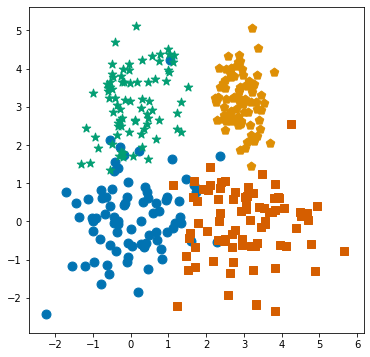

In [0]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.


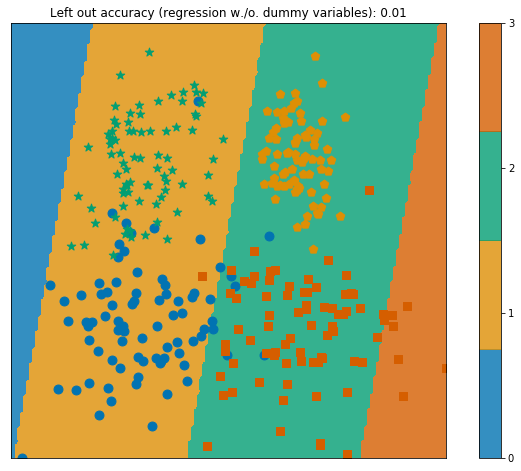

Durée d'éxecution de l'algorithme :0.0011119842529296875s


In [0]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################
resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
debut=time.time()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)
fin=time.time()
# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()
print("Durée d'éxecution de l'algorithme :"+str(fin-debut)+'s')

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

Le modèle ordinaire considère les classes comme ordonnées même si elles ne les sont pas. On observe donc que les regressions sont parallèles, car la classe 1 doit nécessairement se trouver entre les classes 0 et 2. 

Au contraire, pour le OneHotEncoder, on observe que les zones associées aux classes 0 et 2 se touchent presque. En effet, les classes sont codées sur $n_   {class}$ valeurs, toutes égales à 0 sauf celle dont l'index correspond à la classe du point. 

Pour deux classes, les résultats sont identiques.
Cette seconde stratégie est meilleure si les classes ne sont pas ordonnées, car la méthode naive interprète la classe comme une caractéristique continue, ce qui biaise la classification. Cependant, pour trois classes on observe que le score de précision avec la méthode OneHotEncoder est légèrement plus faible que celui de la méthode ordinaire. Cela dépend des données et du modèle étudié, mais si généralement, dans le cas où les classes ne sont pas ordonnées, le OneHotEncoder aura de biens meilleurs résultats. Dans le cas à quatre classes la méthode OneHotEncoder est beaucoup plus efficace, tandis que la méthode naive à un score de précision proche de zéro. 
Au contraire si les classes sont ordonnées, le meilleur résultat sera obtenu avec la régression naïve. 


In [0]:
def confusion_matrix(y_test,y_sol):
  l=int(max(y_test))+1
  M=np.zeros((l,l))
  for i in range(len(y_test)):
    m=int(y_test[i])
    n=int(y_sol[i])
    M[m][n]+=1
  return M

print("Confusion Matrix with the naive linear regression : ")
print(str(confusion_matrix(y_pred_test,y_test)))

Confusion Matrix with the naive linear regression : 
[[ 0.  0.  0.  0.]
 [18.  0. 24.  0.]
 [ 3. 18.  0. 16.]
 [ 0.  0.  0.  1.]]


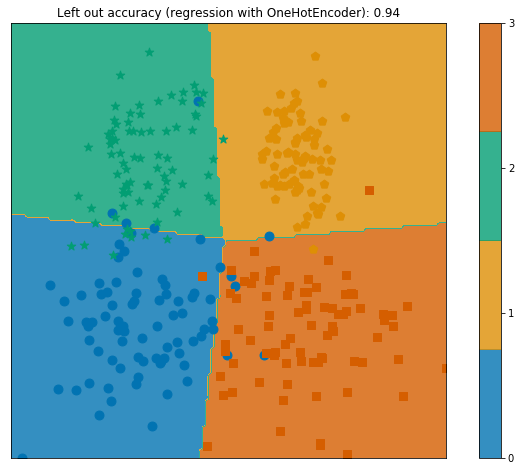

Durée d'éxecution de l'algorithme :0.0036885738372802734s
Confusion Matrix with the OneHotEncoder linear regression : 
[[18.  0.  2.  0.]
 [ 1. 18.  0.  0.]
 [ 0.  0. 22.  0.]
 [ 2.  0.  0. 17.]]


In [0]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150  
enc = OneHotEncoder(categories='auto')
debut=time.time()
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)
proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)
fin=time.time()
# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()
print("Durée d'éxecution de l'algorithme :"+str(fin-debut)+'s')
print("Confusion Matrix with the OneHotEncoder linear regression : ")
print(str(confusion_matrix(y_pred_test,y_test)))

Let's use the other strategies seen this morning.

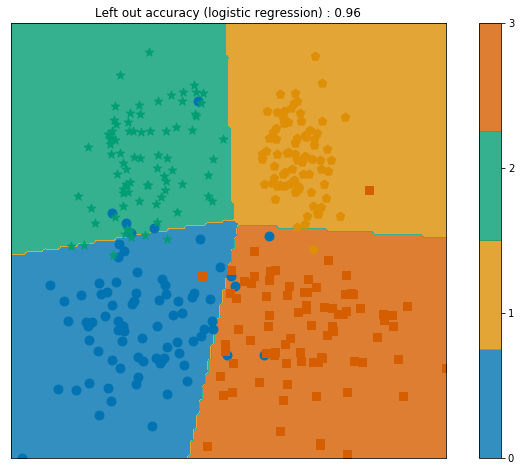

Durée d'éxecution de l'algorithme :0.0215911865234375s
Confusion Matrix with the Logistic regression : 
[[19.  0.  1.  0.]
 [ 0. 18.  0.  0.]
 [ 0.  0. 23.  0.]
 [ 2.  0.  0. 17.]]


In [0]:
##############################################################################
# Logistic regression
##############################################################################
resolution_param = 150  
clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial', 
debut=time.time()
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
fin=time.time()
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()
print("Durée d'éxecution de l'algorithme :"+str(fin-debut)+'s')
print("Confusion Matrix with the Logistic regression : ")
print(str(confusion_matrix(y_logit_test,y_test)))

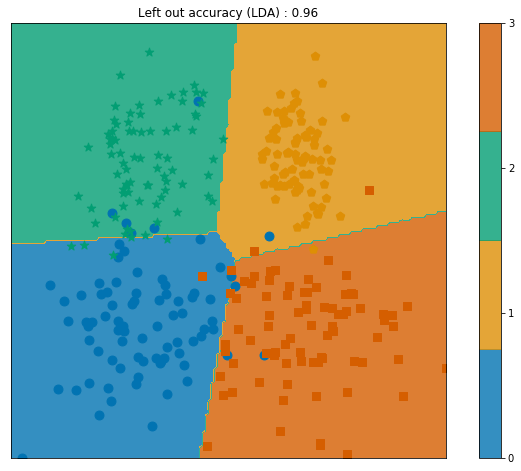

Durée d'éxecution de l'algorithme :0.004323244094848633s
Confusion Matrix with the LDA : 
[[19.  0.  1.  0.]
 [ 1. 18.  0.  0.]
 [ 0.  0. 23.  0.]
 [ 1.  0.  0. 17.]]


In [0]:
##############################################################################
# LDA
##############################################################################

resolution_param = 150  
clf_LDA = LinearDiscriminantAnalysis()
debut=time.time()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)
fin=time.time()
title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()
print("Durée d'éxecution de l'algorithme :"+str(fin-debut)+'s')
print("Confusion Matrix with the LDA : ")
print(str(confusion_matrix(y_LDA_test,y_test)))

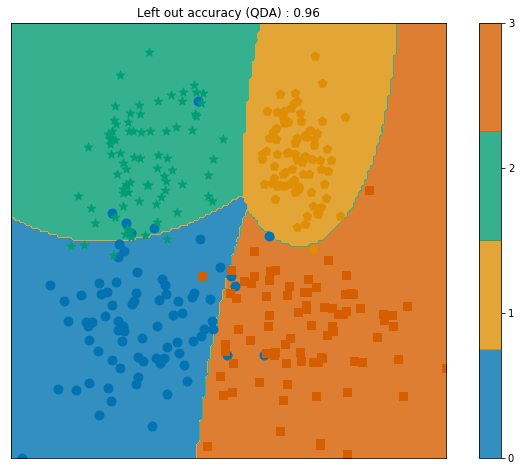

Durée d'éxecution de l'algorithme :0.002168416976928711s
Confusion Matrix with the QDA : 
[[19.  0.  1.  0.]
 [ 1. 18.  0.  0.]
 [ 0.  0. 23.  0.]
 [ 1.  0.  0. 17.]]


In [0]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150 
clf_QDA = QuadraticDiscriminantAnalysis()
debut=time.time()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
fin=time.time()
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()
print("Durée d'éxecution de l'algorithme :"+str(fin-debut)+'s')
print("Confusion Matrix with the QDA : ")
print(str(confusion_matrix(y_QDA_test,y_test)))

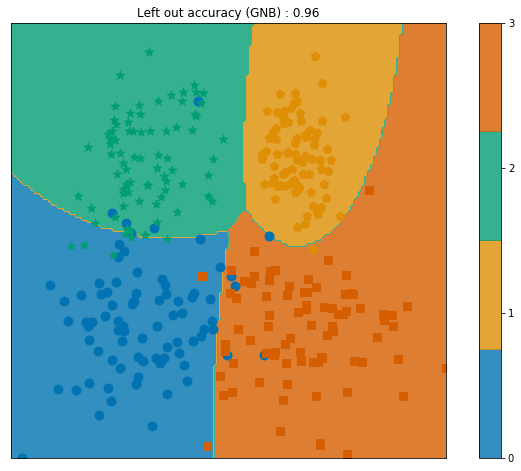

Durée d'éxecution de l'algorithme :0.0018897056579589844s
Confusion Matrix with the Naive Bayes : 
[[19.  0.  1.  0.]
 [ 1. 18.  0.  0.]
 [ 0.  0. 23.  0.]
 [ 1.  0.  0. 17.]]


In [0]:
##############################################################################
# Naive Bayes 
##############################################################################

resolution_param = 150  
clf_GNB = GaussianNB()
debut=time.time()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)
fin=time.time()
title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()
print("Durée d'éxecution de l'algorithme :"+str(fin-debut)+'s')
print("Confusion Matrix with the Naive Bayes : ")
print(str(confusion_matrix(y_test_GNB,y_test)))

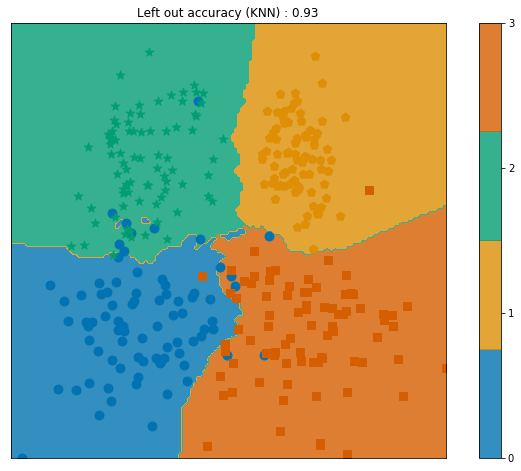

Durée d'éxecution de l'algorithme :0.006922483444213867s
Confusion Matrix with the KNN : 
[[16.  0.  0.  1.]
 [ 0. 18.  0.  0.]
 [ 2.  0. 24.  0.]
 [ 3.  0.  0. 16.]]


In [0]:
##############################################################################
# KNN
##############################################################################

resolution_param = 150  
clf_KNN = KNeighborsClassifier()
clf_KNN.n_neighbors=5
debut=time.time()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
fin=time.time()
title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()
print("Durée d'éxecution de l'algorithme :"+str(fin-debut)+'s')
print("Confusion Matrix with the KNN : ")
print(str(confusion_matrix(y_KNN_test,y_test)))

**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?
*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.
* (Optional) If you change the number of samples per class (both training and test), do the results vary ?



In [0]:
# Logistic Regression
time_start = time.perf_counter()
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('--Logistic Regression-- ')
print('Computational time :', "%.3f" %time_elapsed, 's ; Test accuracy :', "%.2f" %accuracy_score(y_test, y_logit_test))
# LDA
time_start = time.perf_counter()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('--LDA-- ')
print('Computational time :', "%.3f" %time_elapsed, 's ; Test accuracy :', "%.2f" %accuracy_score(y_test, y_LDA_test))
#QDA
time_start = time.perf_counter()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('--QDA-- ')
print('Computational time :', "%.3f" %time_elapsed, 's ; Test accuracy :', "%.2f" %accuracy_score(y_test, y_QDA_test))
# Naive Bayer
time_start = time.perf_counter()
clf_GNB.fit(X_train, y_train)
y_test_GNB = clf_GNB.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('--Naive Bayes-- ')
print('Computational time :', "%.3f" %time_elapsed, 's ; Test accuracy :', "%.2f" %accuracy_score(y_test, y_test_GNB))
#KNN
time_start = time.perf_counter()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('--KNN-- ')
print('Computational time :', "%.3f" %time_elapsed, 's ; Test accuracy :', "%.2f" %accuracy_score(y_test, y_KNN_test))

--Logistic Regression-- 
Computational time : 0.020 s ; Test accuracy : 0.96
--LDA-- 
Computational time : 0.002 s ; Test accuracy : 0.96
--QDA-- 
Computational time : 0.001 s ; Test accuracy : 0.96
--Naive Bayes-- 
Computational time : 0.001 s ; Test accuracy : 0.96
--KNN-- 
Computational time : 0.005 s ; Test accuracy : 0.93


Les méthodes Logistic Regression et LDA sont linéaires, la frontière choisie est un hyperplan. Les autres ne le sont pas. Les méthodes non linéaires permettent d'obtenir des formes de cluster arrondies, adaptées si l'on voulait par exemple isoler un groupe de données encerclées par d'autres.

Naive Bayes approxime le prior et la probabilité d'obtenir un classe donnée selon chaque caractéristique $x_i$ de X, puis maximise le maximum de vraisemblance.

Logistic Regression effectue une régression linéaire sur les probabilités d'appartenance à une certaine classe.

LDA comme QDA utilisent une analyse d'un discriminant. En chaque point le signe de ce discriminant indique si le point appartient à telle classe ou non. Dans le cas de LDA ce discriminant est linéaire, et quadratique dans le cas de QDA.

KNN attribue une classe à chaque point selon les classes des points de son voisinage. 



Les algorithmes QDA et Naive Bayes sont ceux qui obtiennent les meilleurs résultats. Naive Bayes est plus rapide que QDA en théorie, puisque l'on suppose que les matrices de covariances sont diagonales. En théorie, Naive Bayes ne devrait pas être très efficace sur nos données, car les variables sont correlées entre elles tandis que Naive Bayes assume que les variables sont indépendantes.
LDA obtient souvent de moins bons résultats que les autres algorithmes. Pourtant les variables sont gaussiennes, conditions pour laquelle LDA est optimal, mais son pouvoir prédicitf est diminué car certaines variables sont correlées. 
Logistic regression semble lente, ce qui est étonnant car il s'agit d'une regression linéaire, habituellement rapide à calculer.
La méthode des K-nearest neighbors est plutôt lente et renvoie des frontières non convexes. 